Problem Statement

Primary Question: Can we accurately predict the presence of heart disease in patients based on their diagnostic test results and clinical measurements?

Business Context: Heart disease remains one of the leading causes of death globally. Early detection through diagnostic screening can significantly improve patient outcomes and reduce healthcare costs. This project simulates a real-world scenario where data scientists work with medical professionals to develop predictive models for clinical decision support.

Challenge: Given a patient's diagnostic test results (blood pressure, cholesterol levels, ECG results, exercise capacity, etc.), predict whether the patient has heart disease or not.

Project Goals

Primary Objectives

Model Development: Build and compare multiple classification algorithms (Decision Trees, Random Forest, Logistic Regression, Support Vector Machines)

Performance Optimization: Use grid search with k-fold cross-validation to optimize model hyperparameters

Model Evaluation: Assess models using appropriate metrics for medical diagnosis (accuracy, precision, recall, F1-score, ROC-AUC)

Feature Analysis: Identify the most important diagnostic indicators for heart disease prediction

Learning Outcomes

● Master classification algorithms and their appropriate use cases

● Understand hyperparameter tuning and cross-validation techniques

● Learn to evaluate models in high-stakes domains (healthcare)

● Practice feature importance analysis and model interpretation

● Develop skills in presenting analytical findings to stakeholders

Dataset Description

Target Variable

● heart_disease: Binary classification (0 = No heart disease, 1 = Heart disease present)

Feature Categories

Demographic Information

● age: Patient age (years)

● sex: Gender (0 = Female, 1 = Male)

Clinical Measurements

● chest_pain_type: Type of chest pain (0-3: Typical angina, Atypical angina, Non-anginal pain, Asymptomatic)

● resting_blood_pressure: Resting blood pressure (mm Hg)

● cholesterol: Serum cholesterol level (mg/dl)

● fasting_blood_sugar: Fasting blood sugar > 120 mg/dl (0 = False, 1 = True)

Diagnostic Test Results

● resting_ecg: Resting electrocardiographic results (0-2)

● max_heart_rate: Maximum heart rate achieved during exercise

● exercise_induced_angina: Exercise-induced angina (0 = No, 1 = Yes)

● st_depression: ST depression induced by exercise relative to rest

● st_slope: Slope of peak exercise ST segment (0-2)

● num_major_vessels: Number of major vessels colored by fluoroscopy (0-3)

● thalassemia: Thalassemia test result (0-3)

In [1]:
import os
import time
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix, roc_curve)
from sklearn.inspection import permutation_importance

In [3]:
# ## 1 — Load data and initial inspection

# %%
# Configuration
DATA_PATH = Path('heart_disease_dataset.csv')  # change to your CSV file
RANDOM_STATE = 42
TEST_SIZE = 0.2
OUTPUT_DIR = Path('output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# %%
# Load dataset
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please place the CSV file there.")

df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
print(df.info())

# Quick head
print(df.head())

Shape: (400, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      400 non-null    int64  
 1   sex                      400 non-null    int64  
 2   chest_pain_type          400 non-null    int64  
 3   resting_blood_pressure   400 non-null    int64  
 4   cholesterol              400 non-null    int64  
 5   fasting_blood_sugar      400 non-null    int64  
 6   resting_ecg              400 non-null    int64  
 7   max_heart_rate           400 non-null    int64  
 8   exercise_induced_angina  400 non-null    int64  
 9   st_depression            400 non-null    float64
 10  st_slope                 400 non-null    int64  
 11  num_major_vessels        400 non-null    int64  
 12  thalassemia              400 non-null    int64  
 13  heart_disease            400 non-null    int64  
dtypes: float6

In [4]:
# ## 1.1 Descriptive statistics and missing values

# %%
print(df.describe(include='all').T)
print('\nMissing values by column:\n', df.isnull().sum())


                         count       mean        std    min    25%    50%  \
age                      400.0   53.66750   8.508403   29.0   48.0   54.0   
sex                      400.0    0.66250   0.473449    0.0    0.0    1.0   
chest_pain_type          400.0    1.71250   1.035628    0.0    1.0    2.0   
resting_blood_pressure   400.0  123.63000  16.567114   94.0  112.0  124.0   
cholesterol              400.0  216.62750  41.379941  126.0  188.0  216.0   
fasting_blood_sugar      400.0    0.14000   0.347422    0.0    0.0    0.0   
resting_ecg              400.0    0.53000   0.533678    0.0    0.0    1.0   
max_heart_rate           400.0  146.71750  21.104293   91.0  132.0  146.0   
exercise_induced_angina  400.0    0.29250   0.455480    0.0    0.0    0.0   
st_depression            400.0    0.75325   0.772841    0.0    0.2    0.6   
st_slope                 400.0    1.17750   0.645784    0.0    1.0    1.0   
num_major_vessels        400.0    0.67750   0.889084    0.0    0.0    0.0   


Target distribution:
heart_disease
1    222
0    178
Name: count, dtype: int64


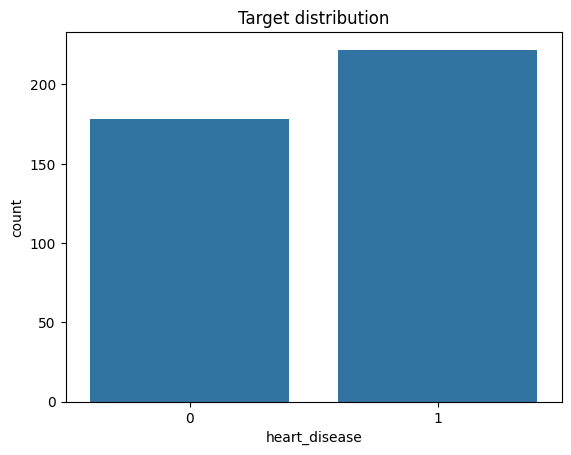

In [5]:
# ## 1.2 Target distribution and class balance

# %%
print('\nTarget distribution:')
print(df['heart_disease'].value_counts())

sns.countplot(x='heart_disease', data=df)
plt.title('Target distribution')
plt.show()

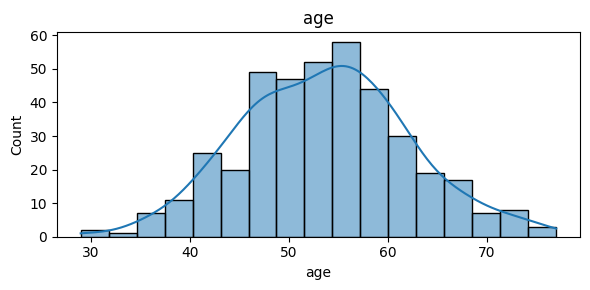

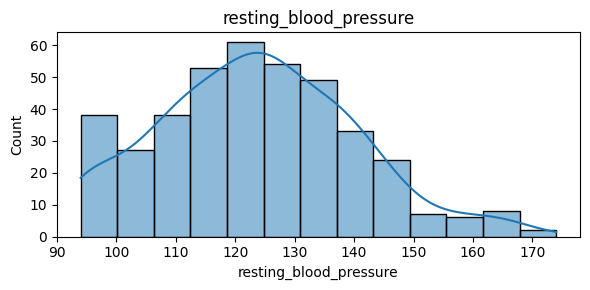

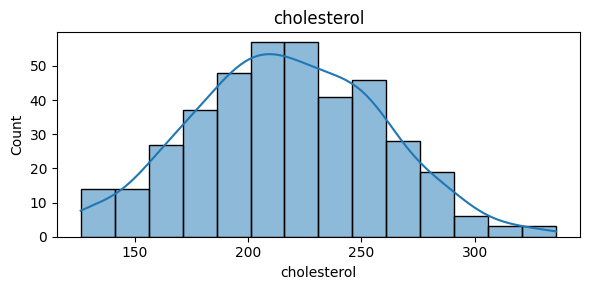

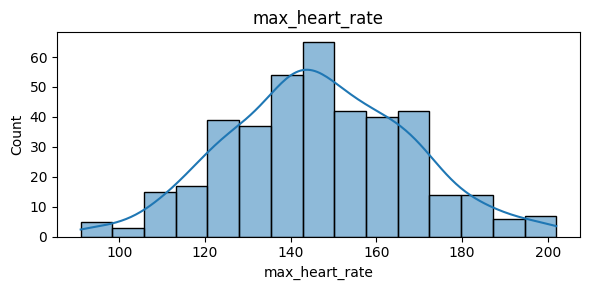

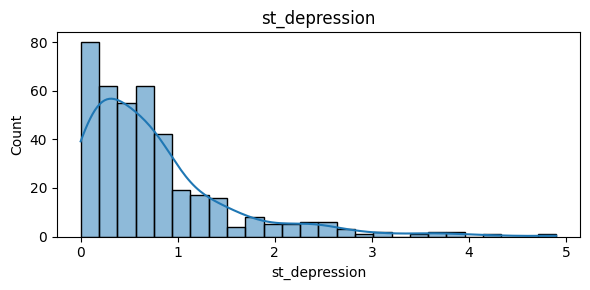

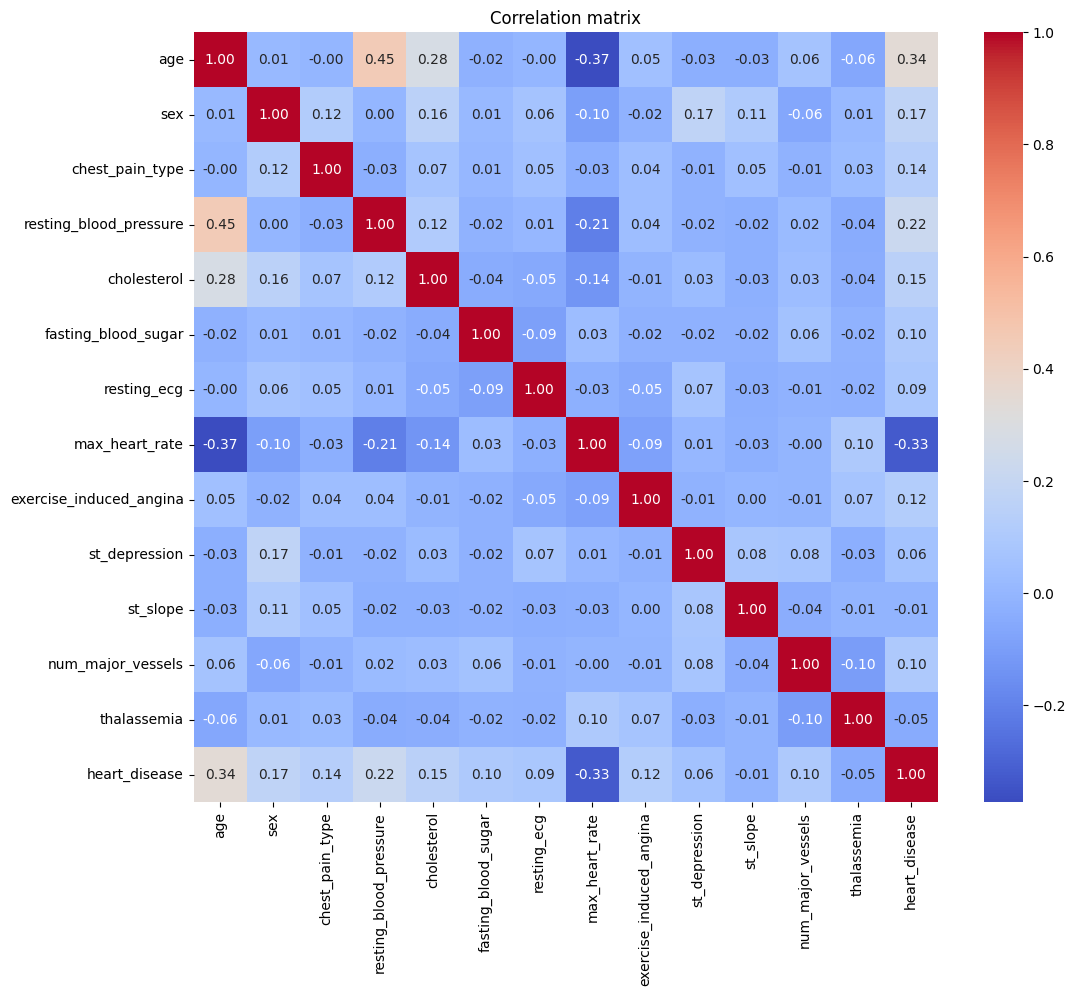

In [6]:
# ## 1.3 Visualizations: distributions and correlations

# %%
# Histograms for continuous features
continuous = ['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate', 'st_depression']
for col in continuous:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(col)
    plt.tight_layout()
    plt.show()

# Correlation heatmap (only numeric columns)
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()


In [7]:
# ## 1.4 Handle outliers (basic) — demonstrate winsorization option

# %%
from scipy.stats import mstats

# winsorize cholesterol as an example (cap extreme values at 1st and 99th percentiles)
for col in ['cholesterol', 'resting_blood_pressure']:
    df[col] = mstats.winsorize(df[col], limits=[0.01, 0.01])

In [8]:
# ## 1.5 Preprocessing: encoding and scaling

# %%
# Define feature lists (based on project brief)
cat_features = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'resting_ecg', 'exercise_induced_angina', 'st_slope', 'num_major_vessels', 'thalassemia']
num_features = ['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate', 'st_depression']

target = 'heart_disease'

# Basic imputation strategy: fill numerical NaNs with median, categorical with mode
from sklearn.impute import SimpleImputer

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# %% [markdown]
# ## 1.6 Train-test split

# %%
X = df[num_features + cat_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (320, 13) Test shape: (80, 13)


In [9]:
# ## 2 — Baseline model development (pipelines)

# %%
# Define model pipelines
models = {
    'DecisionTree': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))]),
    'RandomForest': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))]),
    'LogisticRegression': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))]),
    'SVM': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC(probability=True, random_state=RANDOM_STATE))])
}

# %%
# Function to evaluate model with cross-validation
def evaluate_model_cv(name, model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    print(f"Evaluating {name} with {cv}-fold CV")
    scores = {s: cross_val_score(model, X, y, cv=skf, scoring=s, n_jobs=-1) for s in scoring}
    results = {s: (scores[s].mean(), scores[s].std()) for s in scores}
    for metric, (mean, std) in results.items():
        print(f"{metric}: {mean:.3f} (+/- {std:.3f})")
    return results

# %%
# Baseline evaluation
baseline_results = {}
for name, pipeline in models.items():
    baseline_results[name] = evaluate_model_cv(name, pipeline, X_train, y_train, cv=5)
    print('\n')

# %% [markdown]
# ## 2.1 Train baseline models and evaluate on test set

# %%
trained_models = {}
for name, pipeline in models.items():
    print('Training', name)
    pipeline.fit(X_train, y_train)
    trained_models[name] = pipeline

    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]

    print(name, 'Test metrics:')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    try:
        print('ROC-AUC:', roc_auc_score(y_test, y_proba))
    except Exception:
        print('ROC-AUC: could not compute (no probabilities)')
    print('\nConfusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('\nClassification report:\n', classification_report(y_test, y_pred))
    print('\n' + '-'*60 + '\n')

Evaluating DecisionTree with 5-fold CV
accuracy: 0.606 (+/- 0.057)
precision: 0.642 (+/- 0.053)
recall: 0.663 (+/- 0.049)
f1: 0.652 (+/- 0.050)
roc_auc: 0.599 (+/- 0.058)


Evaluating RandomForest with 5-fold CV
accuracy: 0.672 (+/- 0.052)
precision: 0.698 (+/- 0.049)
recall: 0.730 (+/- 0.057)
f1: 0.712 (+/- 0.042)
roc_auc: 0.728 (+/- 0.063)


Evaluating LogisticRegression with 5-fold CV
accuracy: 0.684 (+/- 0.059)
precision: 0.719 (+/- 0.062)
recall: 0.724 (+/- 0.061)
f1: 0.719 (+/- 0.045)
roc_auc: 0.743 (+/- 0.044)


Evaluating SVM with 5-fold CV
accuracy: 0.675 (+/- 0.057)
precision: 0.694 (+/- 0.049)
recall: 0.747 (+/- 0.038)
f1: 0.720 (+/- 0.043)
roc_auc: 0.716 (+/- 0.068)


Training DecisionTree
DecisionTree Test metrics:
Accuracy: 0.675
Precision: 0.6875
Recall: 0.75
F1: 0.717391304347826
ROC-AUC: 0.6666666666666666

Confusion matrix:
[[21 15]
 [11 33]]

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.58      0.62    

                      feature  importance
3              max_heart_rate    0.145670
0                         age    0.127223
2                 cholesterol    0.117076
1      resting_blood_pressure    0.116548
4               st_depression    0.086833
6                       sex_1    0.028909
5                       sex_0    0.028348
10          chest_pain_type_3    0.026525
21        num_major_vessels_0    0.026047
22        num_major_vessels_1    0.023019
19                 st_slope_1    0.021951
16  exercise_induced_angina_0    0.019950
8           chest_pain_type_1    0.019524
20                 st_slope_2    0.019453
13              resting_ecg_0    0.018757
27              thalassemia_2    0.018686
17  exercise_induced_angina_1    0.017326
9           chest_pain_type_2    0.017275
14              resting_ecg_1    0.016795
11      fasting_blood_sugar_0    0.014092


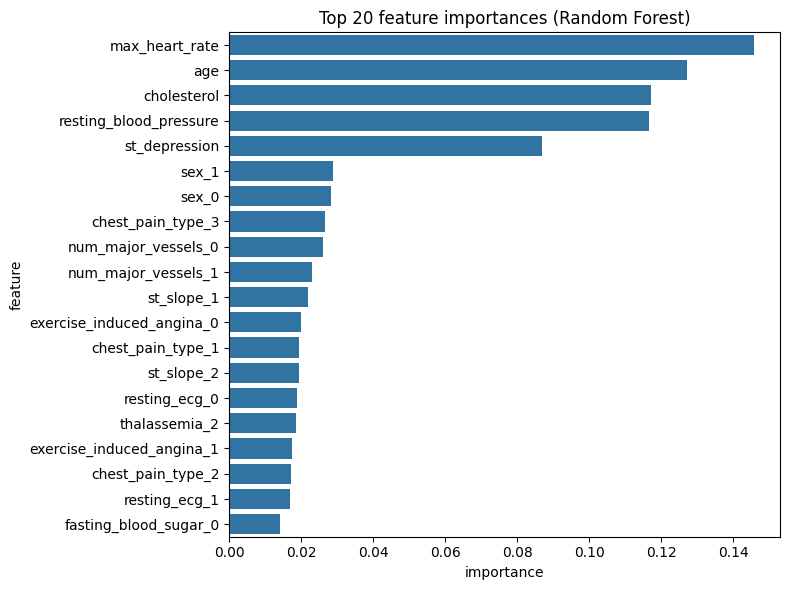

Permutation importance on logistic regression...
                   feature  importance_mean
0                      age     5.750000e-02
3           max_heart_rate     3.750000e-02
14           resting_ecg_1     1.375000e-02
1   resting_blood_pressure     1.000000e-02
19              st_slope_1     5.000000e-03
15           resting_ecg_2     3.750000e-03
18              st_slope_0     3.750000e-03
28           thalassemia_3     3.750000e-03
12   fasting_blood_sugar_1     2.500000e-03
11   fasting_blood_sugar_0     2.500000e-03
20              st_slope_2     2.500000e-03
22     num_major_vessels_1     2.500000e-03
9        chest_pain_type_2     1.250000e-03
8        chest_pain_type_1     1.250000e-03
24     num_major_vessels_3     2.220446e-17
25           thalassemia_0     0.000000e+00
23     num_major_vessels_2     0.000000e+00
10       chest_pain_type_3    -3.750000e-03
21     num_major_vessels_0    -1.000000e-02
13           resting_ecg_0    -1.125000e-02


In [20]:
# ## 3 — Feature importance and interpretation

# %%
# For tree-based models: extract feature names after preprocessing
def get_feature_names(preprocessor):
    # numeric features remain same
    num_feats = num_features
    # one-hot encoder feature names
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    try:
        cat_names = ohe.get_feature_names_out(cat_features).tolist()
    except Exception:
        cat_names = ohe.get_feature_names(cat_features).tolist()
    return num_feats + cat_names

# Example using RandomForest optimized model
if 'RandomForest' in trained_models:
    rf_best = trained_models['RandomForest']
    rf_clf = rf_best.named_steps['classifier']
    feat_names = get_feature_names(rf_best.named_steps['preprocessor'])
    importances = rf_clf.feature_importances_
    fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
    print(fi_df.head(20))

    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=fi_df.head(20))
    plt.title('Top 20 feature importances (Random Forest)')
    plt.tight_layout()
    plt.show()

# Permutation importance (model-agnostic)
if 'LogisticRegression' in trained_models:
    lr_best = trained_models['LogisticRegression']
    print('Permutation importance on logistic regression...')
    X_test_trans = lr_best.named_steps['preprocessor'].transform(X_test)
    perm = permutation_importance(lr_best.named_steps['classifier'], X_test_trans, y_test, n_repeats=10, random_state=RANDOM_STATE)
    # map back names
    feat_names = get_feature_names(lr_best.named_steps['preprocessor'])
    perm_df = pd.DataFrame({'feature': feat_names, 'importance_mean': perm.importances_mean}).sort_values('importance_mean', ascending=False)
    print(perm_df.head(20))

In [21]:
# ## 4 — Save final models and preprocessing objects

# %%
# Choose a final model (example: best by ROC-AUC on test set). We'll pick RandomForest if available.
final_model_name = None
if trained_models:
    # naive selection by test ROC-AUC
    best_score = -1
    for name, model in trained_models.items():
        try:
            y_proba = model.predict_proba(X_test)[:,1]
            score = roc_auc_score(y_test, y_proba)
            if score > best_score:
                best_score = score
                final_model_name = name
        except Exception:
            continue

print('Selected final model:', final_model_name, 'with ROC-AUC:', best_score)

if final_model_name:
    final_model = trained_models[final_model_name]
    with open(OUTPUT_DIR / 'final_model_pipeline.pkl', 'wb') as f:
        pickle.dump(final_model, f)
    print('Saved final_model_pipeline.pkl')

    # Save model metadata
    metadata = {
        'model_name': final_model_name,
        'roc_auc_test': float(best_score),
        'features': num_features + cat_features
    }
    pd.Series(metadata).to_json(OUTPUT_DIR / 'final_model_metadata.json')

Selected final model: LogisticRegression with ROC-AUC: 0.7645202020202021
Saved final_model_pipeline.pkl
